In [15]:
import torch
import os
from model_lorentz import GPTConfig, GPT

root_dir = "/raid/out-tinystories"  # Adjust this path if necessary

# Get a list of all experiment folders
ckpt_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)]

ckpt_dirs

['/raid/out-tinystories/ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.10.pt',
 '/raid/out-tinystories/ckpt_mode_original_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.15.pt',
 '/raid/out-tinystories/ckpt_cmode_fixed_init_curvature_0.01_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.13.pt',
 '/raid/out-tinystories/ckpt_cmode_learned_init_curvature_0.01_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.12.pt',
 '/raid/out-tinystories/ckpt_cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.11.pt']

In [35]:
checkpoint_path = ckpt_dirs[-2]
print(checkpoint_path)
# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Load the model arguments from the checkpoint
model_args = checkpoint['model_args']

# Initialize the model with the loaded config
gpt_config = GPTConfig(**model_args)
model = GPT(gpt_config)

# Load the model state dictionary
state_dict = checkpoint['model']

# Remove unwanted prefix if present
unwanted_prefix = '_orig_mod.'
for k in list(state_dict.keys()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

# Load state dict into the model
model.load_state_dict(state_dict)

/raid/out-tinystories/ckpt_cmode_learned_init_curvature_0.01_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.12.pt
number of parameters: 4.37M


<All keys matched successfully>

In [36]:
# Iterate through the layers and print the value of the 'c' parameter in hyperbolic mode
for i, block in enumerate(model.transformer.h):
    # if isinstance(block.attn, CausalSelfAttention) and block.attn.mode == 'hyperbolic':
    print(f"Layer {i} c:", end=' ')
    [print(f"{w.item():.3f}", end=' ') for w in block.attn.c.flatten()]
    print('\n')

Layer 0 c: 0.308 0.374 0.091 0.131 0.104 0.167 0.232 0.132 0.264 0.477 0.203 0.289 

Layer 1 c: 0.149 0.076 0.066 0.057 0.081 0.130 0.094 0.315 0.079 0.195 0.128 0.127 

Layer 2 c: 0.213 0.086 0.090 0.201 0.061 0.082 0.130 0.066 0.127 0.086 0.231 0.057 

Layer 3 c: 0.445 0.138 0.137 0.067 0.462 0.132 0.088 0.162 0.242 0.075 0.307 0.093 

Layer 4 c: 1.165 0.054 0.108 0.193 0.217 0.814 0.073 0.211 0.223 0.048 0.847 0.303 

Layer 5 c: 0.955 0.555 1.344 0.568 0.045 0.727 1.337 0.066 0.103 0.601 1.121 1.269 

Layer 6 c: 0.140 1.157 1.766 1.046 1.463 0.741 0.465 1.642 0.955 1.688 0.515 0.410 

Layer 7 c: 1.718 1.515 1.421 0.544 0.236 0.125 0.292 0.349 1.360 0.658 2.071 1.557 

Layer 8 c: 2.155 1.106 1.751 2.378 1.461 1.690 1.239 0.182 1.863 2.029 1.602 0.260 

Layer 9 c: 1.655 0.516 0.190 0.383 2.352 0.623 0.398 1.133 1.243 2.336 1.252 1.313 

Layer 10 c: 0.758 1.175 0.551 1.361 0.115 0.075 1.353 0.134 1.396 0.809 1.792 1.033 

Layer 11 c: 0.689 0.204 0.231 0.203 0.205 0.519 0.218 0.210 0.17

In [29]:
for i, block in enumerate(model.transformer.h):
    for name, param in block.named_parameters():
        print(f"Name: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")
    break

Name: ln_1.weight | Shape: torch.Size([72]) | Requires Grad: True
Name: attn.c | Shape: torch.Size([1, 12, 1, 1]) | Requires Grad: True
Name: attn.c_attn.weight | Shape: torch.Size([216, 72]) | Requires Grad: True
Name: attn.c_proj.weight | Shape: torch.Size([72, 72]) | Requires Grad: True
Name: ln_2.weight | Shape: torch.Size([72]) | Requires Grad: True
Name: mlp.c_fc.weight | Shape: torch.Size([288, 72]) | Requires Grad: True
Name: mlp.c_proj.weight | Shape: torch.Size([72, 288]) | Requires Grad: True


In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Define the path to your root logs directory
root_log_dir = "/raid/runs_train/10.02"  # Adjust this path if necessary

# Get a list of all experiment folders
log_dirs = [os.path.join(root_log_dir, d) for d in os.listdir(root_log_dir)]

log_dirs

['/raid/runs_train/10.02/cmode_learned_init_curvature_0.01_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.12',
 '/raid/runs_train/10.02/cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.11',
 '/raid/runs_train/10.02/mode_original_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.15',
 '/raid/runs_train/10.02/cmode_learned_init_curvature_1.0_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.10',
 '/raid/runs_train/10.02/cmode_fixed_init_curvature_0.01_n_layer_12_n_head_12_n_embd_72_learning_rate_0.0003_min_lr_3e-05_lr_decay_iters_40000_batch_size_1_gradient_accumulation_steps_2_21.13']

In [30]:
log_dirs_bs1 = [log_dirs[0], log_dirs[2]]
log_dirs_bs2 = [log_dirs[1], log_dirs[2]]
log_dirs_o = log_dirs[:4]
log_dirs_l = log_dirs[4:]

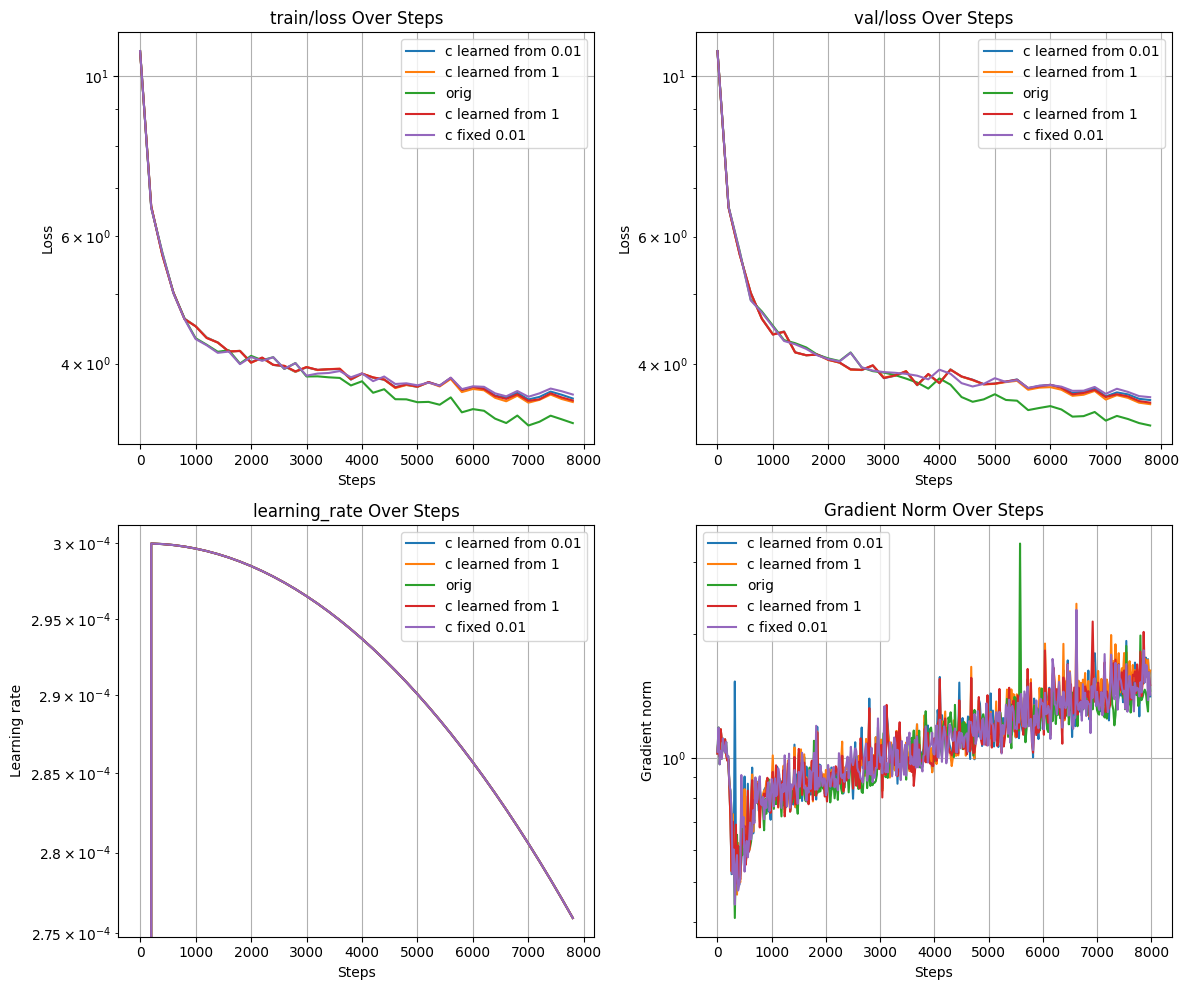

In [12]:
logs_to_show=log_dirs
# exp_names = [n[-15:] for n in logs_to_show]
exp_names = ['c learned from 0.01', 'c learned from 1', 'orig', 'c learned from 1', 'c fixed 0.01']

# Initialize a dictionary to hold data for each experiment
experiment_data = {}

for log_dir in logs_to_show:
    # Load TensorBoard logs
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Get available scalar tags (train/loss, val/loss, learning_rate, Gradient Norm)
    tags = ['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']
    
    # Extract and store scalar values for each tag
    data = {}
    for tag in tags:
        if tag in event_acc.Tags().get('scalars', []):  # Check if tag is available
            scalars = event_acc.Scalars(tag)
            steps = [s.step for s in scalars]
            values = [s.value for s in scalars]
            data[tag] = {'steps': steps, 'values': values}
    
    # Store the extracted data for this experiment folder
    experiment_data[os.path.basename(log_dir)] = data


metrics = ['train/loss', 'val/loss', 'learning_rate', 'Gradient Norm']

# exp_names = ['hyperbolic c=1e-5', 'original']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid

# Flatten the axs array for easy iteration
axs = axs.ravel()

# Loop over each metric and create a plot
for i, metric in enumerate(metrics):
    ax = axs[i]
    
    for (experiment, data), e in zip(experiment_data.items(), exp_names):
        if metric in data:
            length = len(data[metric]['steps'])
            plot_length = int(0.2*length)
            steps = data[metric]['steps'][:plot_length]
            values = data[metric]['values'][:plot_length]
            ax.plot(steps, values, label=e)
    
    # if not 'loss' in metric:
    ax.set_yscale('log')  # Set y-axis to logarithmic scale
    ax.set_xlabel('Steps')
    # ax.set_xlim([0, 1.1*max(steps)])
    ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').capitalize())  # Clean y-axis label
    ax.set_title(f'{metric} Over Steps')
    ax.grid(True)  # Add grid
    ax.legend()

plt.tight_layout()
# plt.savefig('runs_head.jpg')
plt.show()

In [5]:
len(values)

2001